In [ ]:
#tfidf -> w2v -> gloVe

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, plot_confusion_matrix
import nltk
import pickle

#specific to this notebook
import spacy
#!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load() 

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [18]:
#Load in data and split for train and test sets
df = pd.read_csv(r'C:\Users\jackc\Semester2\Project\Identifying-Hate-Speech-Categories-On-Social-Media\Data\clean_dataset.csv')
X_train, X_test, y_train, y_test = train_test_split(df['text_lemma'], df['Hate'], test_size=0.25, random_state=12)
                                                       
df.head(5)

,id,text,Annotation,tokenized_text,text_lemma,pos_tags,Hate
0,5.969655e+17,i just found the perfect rental why cant my le...,Neither,"['found', 'perfect', 'rental', 'cant', 'lease'...","['found', 'perfect', 'rental', 'cant', 'lease'...","['i_NN', 'just_RB', 'found_VBD', 'the_DT', 'pe...",0
1,5.758918e+17,every time they discover anything its either ...,Neither,"['every', 'time', 'discover', 'anything', 'eit...","['every', 'time', 'discover', 'anything', 'eit...","['every_DT', 'time_NN', 'they_PRP', 'discover_...",0
2,5.952595e+17,ok time to write code bbl\n\nmaking a new thing,Neither,"['ok', 'time', 'write', 'code', 'bbl', 'making...","['ok', 'time', 'write', 'code', 'bbl', 'making...","['ok_JJ', 'time_NN', 'to_TO', 'write_VB', 'cod...",0
3,5.723449e+17,refined dessert not mkr,Neither,"['refined', 'dessert', 'mkr']","['refined', 'dessert', 'mkr']","['refined_VBN', 'dessert_NN', 'not_RB', 'mkr_VB']",0
4,5.681320e+17,one of the best things anyone can do to impr...,Neither,"['one', 'best', 'things', 'anyone', 'improve',...","['one', 'best', 'thing', 'anyone', 'improve', ...","['one_CD', 'of_IN', 'the_DT', 'best_JJS', 'thi...",0


In [19]:
%%time
def get_vec(x):
  doc = nlp(x)
  return doc.vector

doc2vec_dataset = df.drop(['id','tokenized_text','text_lemma', 'pos_tags'],axis = 1).copy()

doc2vec_dataset['vec'] = doc2vec_dataset['text'].apply(lambda x: get_vec(x))

doc2vec_dataset.head()

Wall time: 44.5 s


,text,Annotation,Hate,vec
0,i just found the perfect rental why cant my le...,Neither,0,"[0.0547106, 0.22135, -0.23980302, -0.15787779,..."
1,every time they discover anything its either ...,Neither,0,"[-0.057143338, 0.14135154, -0.27148843, 0.0042..."
2,ok time to write code bbl\n\nmaking a new thing,Neither,0,"[0.0057974537, 0.13553664, -0.23749961, -0.046..."
3,refined dessert not mkr,Neither,0,"[-0.13199374, 0.09915501, 0.08181499, -0.27303..."
4,one of the best things anyone can do to impr...,Neither,0,"[-0.047892362, 0.08786684, -0.20262949, -0.039..."


In [20]:
# load the model from disk
default_SVM = pickle.load(open('default_svm.sav', 'rb'))
#grid_SVM = pickle.load(open('grid_svm.sav', 'rb'))
grid_SVM = svm.SVC(C=10, class_weight='balanced', coef0=1, degree=5, gamma=0.01, kernel='poly',
    random_state=12)

In [21]:
XX = doc2vec_dataset['vec'].to_numpy()
XX = XX.reshape(-1,1)
XX = np.concatenate(np.concatenate(XX,axis = 0),axis = 0).reshape(-1,300)
XX.shape

(6836, 300)

In [22]:
yy = doc2vec_dataset['Hate']

In [23]:
%%time

lr1 = LogisticRegression(max_iter=100)

accuracy = []
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(XX, yy)
for clf in (lr1,default_SVM, grid_SVM):

    StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
    for train_index, test_index in skf.split(XX, yy):
            
            X1_train, X1_test = XX[train_index], XX[test_index]
            y1_train, y1_test = yy[train_index], yy[test_index]

            model = clf.fit(X1_train,y1_train)
            y_preds = model.predict(X1_test)
            acc = (sklearn.metrics.f1_score(y1_test,y_preds,average = 'micro'))
            accuracy.append(acc)
    print(clf.__class__.__name__,np.array(accuracy).mean())

LogisticRegression 0.8794589573005231
SVC 0.8848706686188385
SVC 0.8752653555150278
Wall time: 2min


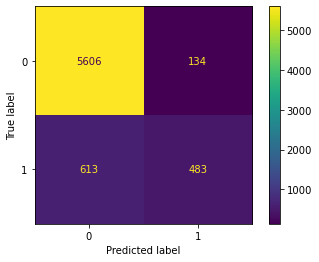

In [24]:
plot_confusion_matrix(lr1, XX, yy)

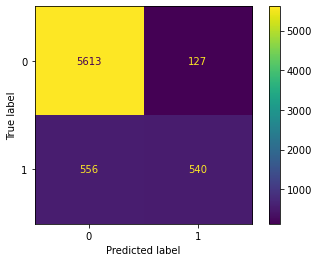

In [25]:
plot_confusion_matrix(default_SVM, XX, yy)

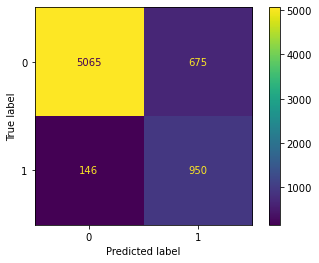

In [26]:
plot_confusion_matrix(grid_SVM, XX, yy)

In [40]:
#Load in data and split for train and test sets
X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.3, random_state=12)

In [41]:
SVM_default = svm.SVC(C=1.0, kernel='rbf', gamma='scale', shrinking=True,
                      class_weight=None, random_state=12)

# train classifier
print("training...")
SVM_default.fit(X_train, y_train)
print("complete.")
# use classifier to predict on test set
print("predicting...")
SVM_test_preds = SVM_default.predict(X_test)
print("complete.")

training...
complete.
predicting...
complete.


In [42]:
SVM_metrics = {}
SVM_default_precision = precision_score(y_test, SVM_test_preds)
SVM_default_recall = recall_score(y_test, SVM_test_preds)
SVM_default_f1_score = f1_score(y_test, SVM_test_preds)
SVM_default_weighted_f1_score = f1_score(y_test, SVM_test_preds, average='weighted')

#model evaluation
print('Model evaluation metrics')
print('Precision: {:.3}'.format(SVM_default_precision))
print('Recall: {:.3}'.format(SVM_default_recall))
print('F1 Score: {:.3}'.format(SVM_default_f1_score))
print('Weighted F1 Score: {:.3}'.format(SVM_default_weighted_f1_score))

SVM_metrics['Default SVM'] = {'precision': SVM_default_precision, 'recall': SVM_default_recall, 
                                  'f1_score': SVM_default_f1_score, 'weighted_f1': SVM_default_weighted_f1_score}

Model evaluation metrics
Precision: 0.827
Recall: 0.467
F1 Score: 0.597
Weighted F1 Score: 0.884


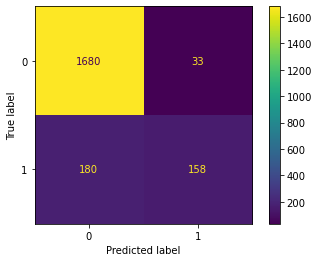

In [43]:
plot_confusion_matrix(SVM_default, X_test, y_test)